### Project Description:
This notebook demonstrates cloud-based deployment using TensorFlow Hub and pretrained models for object detection and image classification. We will utilize Faster R-CNN for detection and VGG16 for classification, leveraging cloud-based models for efficient inference.

### Key Objectives:
✅ Load models from TFHub & PyTorch

✅ Perform object detection using Faster R-CNN

✅ Classify images using VGG16

✅ Optimize cloud-based inference for deployment


### Notebook Sections:

🔹 Setup & Dependencies

🔹 Object Detection (PyTorch Faster R-CNN)

🔹 Object Detection (TFHub Faster R-CNN)

🔹 Image Classification (VGG16 Keras)

🔹 Results & Visualization

⚡ Why Cloud Deployment?

Using TFHub & cloud models enables faster inference without high local computation requirements, making AI more scalable and accessible.



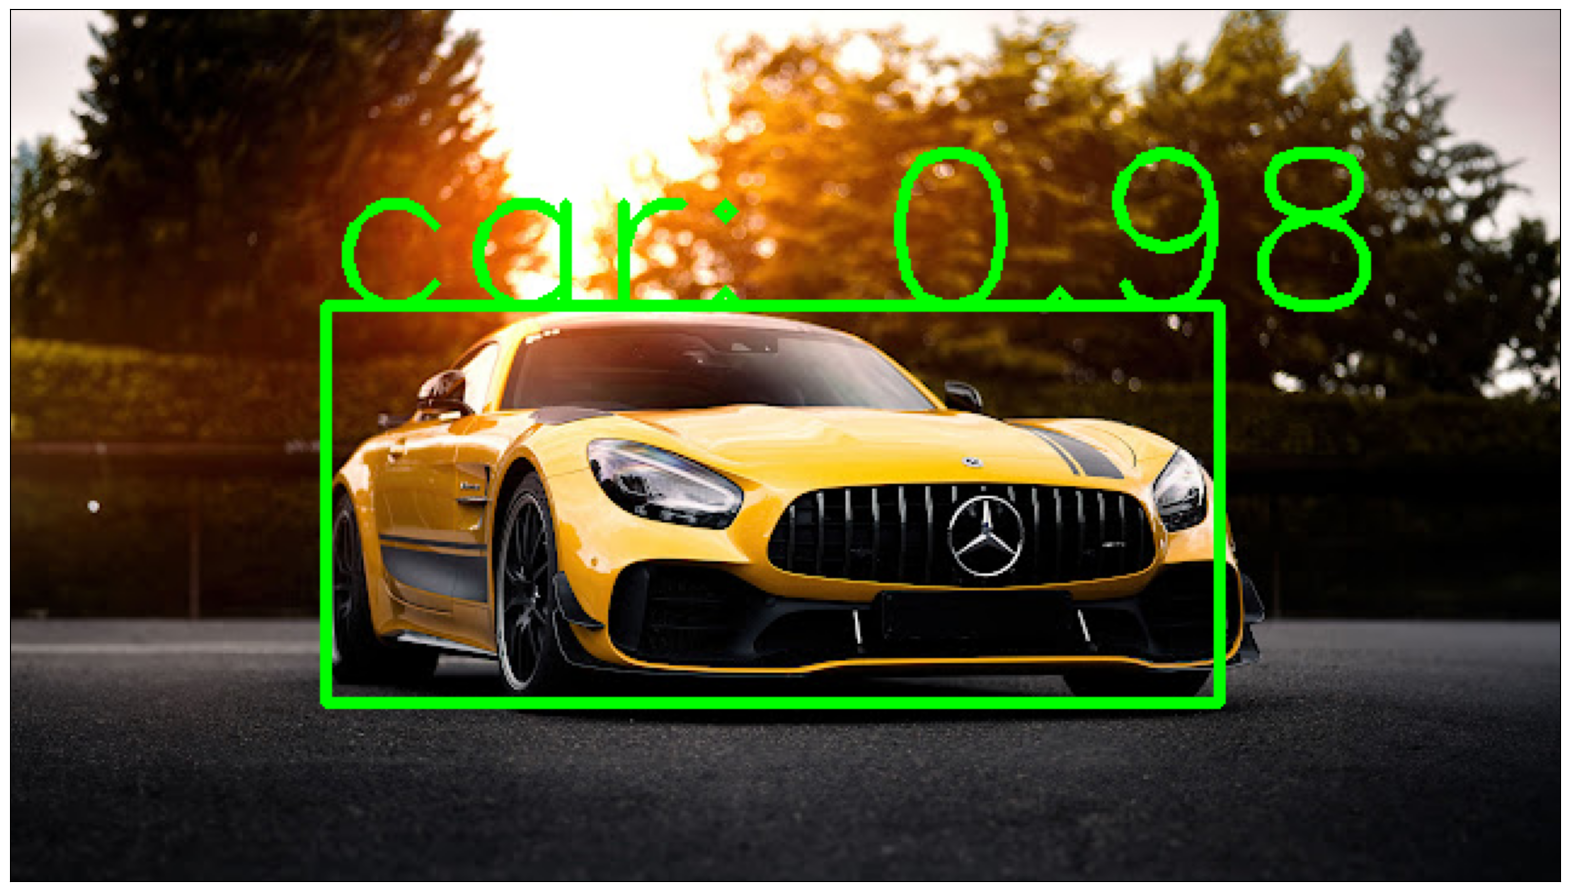

In [16]:
import torch
import torchvision
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval()

# List of category names (COCO dataset)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Function to get predictions
def get_prediction(img_path, threshold):
    img = Image.open(img_path)  # Load the image
    transform = T.Compose([T.ToTensor()])  # Convert image to tensor
    img = transform(img)
    pred = model([img])  # Make predictions using the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]  # Get predicted class names
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]  # Get bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    
    # Get indices where prediction score is above the threshold
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class, pred_score

# Object detection function
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls, pred_scores = get_prediction(img_path, threshold)  # Get predictions
    img = cv2.imread(img_path)  # Read image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    
    plt.figure(figsize=(20,30))  # Display image
    for i in range(len(boxes)):
        # Draw bounding boxes around detected objects
        cv2.rectangle(img, 
                      (int(boxes[i][0][0]), int(boxes[i][0][1])), 
                      (int(boxes[i][1][0]), int(boxes[i][1][1])), 
                      color=(0, 255, 0), thickness=rect_th)
        
        # Display class name with confidence score
        text = f"{pred_cls[i]}: {pred_scores[i]:.2f}"  # Class name + confidence score
        cv2.putText(img, 
                    text, 
                    (int(boxes[i][0][0]), int(boxes[i][0][1])), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    text_size, 
                    (0, 255, 0), 
                    thickness=text_th)
    
    plt.imshow(img)
    plt.xticks([]) 
    plt.yticks([])
    plt.show()

# Define image path
image_path = "/kaggle/input/carrr-r/AMG GTR  4K.jpg"  # Update with the correct image path

# Run object detection model
object_detection_api(image_path)


In [1]:
!pip install tensorflow tensorflow_hub opencv-python-headless matplotlib


Found 100 objects.
Inference time:  37.28146934509277


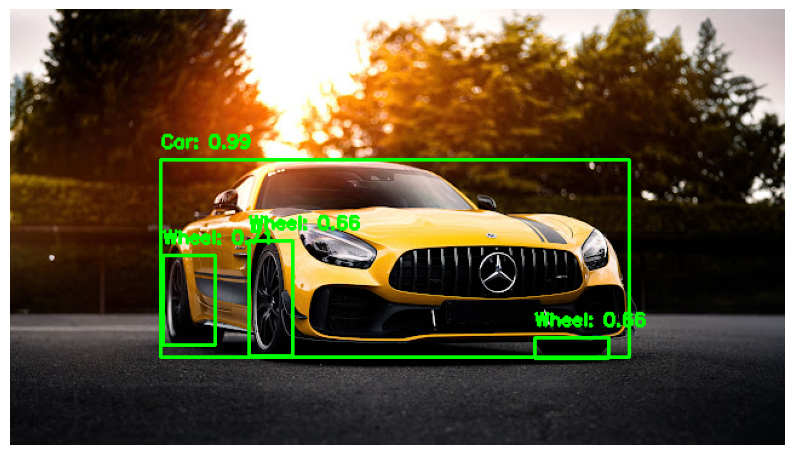

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import time
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the model from TensorFlow Hub
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

# Function to load an image
def load_img(path):
    img = Image.open(path).convert("RGB")  # Ensure the image is in RGB format
    return np.array(img)

# Function to draw bounding boxes on the image
def draw_boxes(image, boxes, class_names, scores, threshold=0.5):
    img = image.copy()
    height, width, _ = img.shape

    for i in range(len(boxes)):
        score = scores[i]
        if score < threshold:
            continue  # Skip objects with confidence below the threshold

        # Extract bounding box coordinates
        y1, x1, y2, x2 = boxes[i]
        x1, y1, x2, y2 = int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)

        # Draw the bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label text
        label = f"{class_names[i].decode('utf-8')}: {score:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img

# Function to run the object detector
def run_detector(detector, path):
    img = load_img(path)

    # Convert image to TensorFlow format
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # Start timing
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # Convert results to NumPy
    result = {key: value.numpy() for key, value in result.items()}
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    # Draw bounding boxes on the image
    image_with_boxes = draw_boxes(
        img, result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"]
    )

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boxes)
    plt.axis("off")
    plt.show()

# Define your image path in Kaggle
image_path = "/kaggle/input/carrr-r/AMG GTR  4K.jpg"

# Run the detector on the image
run_detector(detector, image_path)


In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np

# ✅ Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# ✅ Define the correct image path
img_path = '/kaggle/input/carrr-r/AMG GTR  4K.jpg'  # 🔄 Change this path according to your image

# ✅ Load the image and resize it to (224, 224)
img = image.load_img(img_path, target_size=(224, 224))

# ✅ Convert the image to a numerical array
x = image.img_to_array(img)

# ✅ Add a batch dimension to make the input shape (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# ✅ Apply preprocessing (normalize the image for VGG16)
x = preprocess_input(x)

# ✅ Run the model to get predictions
preds = model.predict(x)

# ✅ Decode the top 3 predictions and display them
decoded_preds = decode_predictions(preds, top=3)[0]
for i, (imagenet_id, label, score) in enumerate(decoded_preds):
    print(f"{i+1}. {label}: {score:.2f}")


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1. cab: 0.45
2. racer: 0.31
3. sports_car: 0.21
